# prep data

### Préparation de l'environnement

Ci-dessous quelques imports et précautions préalables à notre travail. Il n'est pas inutile de les parcourir.
Si nécessaire créer un bloc au démarrage pour installer toutes les librairies nécessaires en exécutant chacune leur tour les commandes suivantes:

In [72]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# stabilité du notebook d'une exécution à l'autre
random=np.random.default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Create Dataframe

In [73]:
def load_data(fileName):
    #csv_path = os.path.join(r'/Users/kenfetet/projects/A4/IA/Projet/Projet_AI_CESI_A4/data/', fileName)
    #csv_path = os.path.join (r'C:\Users\Nico\OneDrive - Association Cesi Viacesi mail\1 - A4 - Informatique\2 - IA\2 - PROJET\Projet_AI_CESI_A4\data', fileName)
    csv_path = os.path.join(r'C:\Users\oscar\OneDrive - Association Cesi Viacesi mail\cours\prosits\A4\ia\projet\data', fileName)
    df = pd.read_csv(csv_path)
    return df

In [74]:
employee_survey_data = load_data('employee_survey_data.csv')
manager_survey_data = load_data('manager_survey_data.csv')
in_time = load_data('in_time.csv')
out_time = load_data('out_time.csv')
general_data = load_data('general_data.csv')

# Choix des données

## Éthique

Dans le cas de notre modèle et de l'utilisation de nos données il est important de déterminer étiquement la conservation de certaines données ou non. 

Pour cela nous avons procédé à un brainstorming et à une lecture des recommendations de la CNIL pour conserver uniquement les données nécessaires et ne prétant pas à une possible discrimination.

Voici la liste des données que nous ne souhaitons pas conserver pour notre modèle :

- **L’âge des employés (Age) :** Nous souhaitons rester dans la plus grande neutralité possible.Effectivement, l’âge ne doit pas nous permettre de définir si une personne est plus à même de quitter l’entreprise ou non. 
<br>

- **Le genre des employés (Gender) :** Le genre est une donnée non pertinante sur les critères qui pousserai à un turnover. Cette donnée pourrait être discrimante 
<br>

- **Le statut marital (MaritalStatus) :** Cette donnée ne nous permetrai pas d’interpreter des critères cohérent concernant les Turn-over dans l’entrprise. Ce serai une surinterpretation des données fournis.

In [75]:
#remove the columns for ethic
general_dataset = general_data.copy()
general_dataset.drop("Age", axis=1, inplace=True)
general_dataset.drop("Gender", axis=1, inplace=True)
general_dataset.drop("MaritalStatus", axis=1, inplace=True)

## Logique

Il est également nécessaire de déterminer d'une manière logique les données utile à conserver ou non. 

Pour cela il suffit d'isoler dans un premier temps les colonnes de la table ***General_data***  ou le champs de valeur est égal à 1, c'est à dire que chaque données est la même.

Pour cela il suffit d'executer cette fonction afin de déterminer les champs répondant à cette condition :

In [76]:
for col in general_data.columns:
    value = general_data[col].nunique()
    value_of = general_data[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


On constate alors que :

- **EmployeeCount :** Cette colonne correspond à la présence ou non d'un employé dans l'entreprise dans les effectifs en 2015, on constate que chaque ligne du tableau est à 1 cela signifie donc que tous les employés présent dans les données était dans l'entreprise en 2015, il n'est donc pas intéressant de conserver cette donnée.
<br>

- **Over18 :** Cette colonne indique si l'age de l'employé est supérieure ou non à 18 ans, on constate que chaque ligne du tableau est à la valeure "Y" cela signifie donc que en 2015 chaque employé était majeur, il n'est donc pas intéressant de conserver cette donnée. 
<br>

- **StandardHours :** Cette colonne spécifie le nombre d'heure inscrite sur le contrat de l'employé, chaque ligne étant positionnée à 8h on en déduit que tous les employés disposait du même type de contrat en 2015. Il n'est donc pas intéressant de conserver cette donnée.

<div class="alert alert-block alert-info">
<b>Info:</b> Cette étude à également été effectuée sur les autres tables mais aucune valeur unique est apparue, nous conserverons alors toutes les données de celles-ci.
</div>

## Conclusion

Après avoir selectionné les données à conserver en fonction de différents facteurs voici une liste exhaustive de celles conservées pour la réalisation de notre modèle :

###  <font color='green'> General_data </font>

- **Attrition :** L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?
<br>

- **BusinessTravel :** A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)
<br>

- **DistanceFromHome :** Distance en km entre le logement de l'employé et l'entreprise.
<br>

- **Education : Niveau d'étude :** 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).
<br>

- **EducationField :** Domaine d'étude, matière principale
<br>

- **EmployeeId :** l'identifiant d'un employé
<br>

- **JobLevel :** Niveau hiérarchique dans l'entreprise de 1 à 5
<br>

- **JobRole :** Métier dans l'entreprise
<br>

- **MonthlyIncome :** Salaire brut en roupies par mois
<br>

- **NumCompaniesWorked :** Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.
<br>

- **PercentSalaryHike :** % d'augmentation du salaire en 2015.
<br>

- **StockOptionLevel :** Niveau d'investissement en actions de l'entreprise par le salarié.
<br>

- **TotalWorkingYears :** Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.
<br>

- **TrainingTimesLastYear :** Nombre de jours de formation en 2015
<br>

- **YearsAtCompany :** Ancienneté dans l'entreprise
<br>

- **YearsSinceLastPromotion :** Nombre d'années depuis la dernière augmentation individuelle
<br>

- **YearsWithCurrentManager :** Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

###  <font color='green'> Employee_survey_data </font>

- **L'environnement de travail :** : noté 1 ("Faible"), 2 ("Moyen"), 3 ("Élevé") ou 4 ("Très élevé") : EnvironmentSatisfaction
<br>

- **Son travail :** noté de 1 à 4 comme précédemment : JobSatisfaction
<br>

- **Son équilibre entre vie professionnelle et vie privée :** noté 1 ("Mauvais"), 2 ("Satisfaisant"), 3 ("Très satisfaisant") ou 4 ("Excellent") : WorkLifeBalance

###  <font color='green'> Manager_survey_data </font>

- **Une évaluation de son implication dans son travail :** notée 1 ('Faible'), 2 ("Moyenne"), 3 ("Importante") ou 4 ("Très importante") : JobInvolvement
<br>

- **Une évaluation de son niveau de performance annuel pour l'entreprise :** notée 1 ("Faible"), 2 ("Bon"), 3 ("Excellent") ou 4 ("Au delà des attentes") : PerformanceRating

In [77]:
# remove the non revelent columns
general_dataset.drop("Over18", axis=1, inplace=True)
general_dataset.drop("EmployeeCount", axis=1, inplace=True)
general_dataset.drop("StandardHours", axis=1, inplace=True)

In [78]:
#merge the dataframes
survey_dataset = pd.merge(employee_survey_data, manager_survey_data, on='EmployeeID')
Dataset = pd.merge(general_dataset, survey_dataset, on='EmployeeID')
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,No,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3


## Encodage

### Encodage binaire de l'attribut Attrition
On convertit les données de l'attribut Attrition, les 'Yes' et 'No' deviennent respectivement des 1 et des 0.

In [84]:
Dataset['Attrition'] = Dataset['Attrition'].map({'Yes': 1, 'No':0}) # convertir la colonne Attrition en 0 et 1

fir_column = Dataset.pop('Attrition') # retirer la colonne Attrition
Dataset.insert(0 ,'Attrition', fir_column) # la remettre en première colonne

### One-Hot Encoding
Nous allons créer des variables supplémentaires pour représenter chacun des catégories.
**BusinessTravel**, **Department**, **EducationField**, **JobRole**

In [85]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False) # sparse=False pour obtenir un tableau numpy (et non une matrice creuse)
data_encoded = onehot_encoder.fit_transform(Dataset[['BusinessTravel', 'Department', 'EducationField', 'JobRole']])
onehot_encoder.categories_ # affiche les catégories

[array(['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'], dtype=object),
 array(['Human Resources', 'Research & Development', 'Sales'], dtype=object),
 array(['Human Resources', 'Life Sciences', 'Marketing', 'Medical',
        'Other', 'Technical Degree'], dtype=object),
 array(['Healthcare Representative', 'Human Resources',
        'Laboratory Technician', 'Manager', 'Manufacturing Director',
        'Research Director', 'Research Scientist', 'Sales Executive',
        'Sales Representative'], dtype=object)]

In [86]:
Dataset.head(3)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,JobLevel,JobRole,MonthlyIncome,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Healthcare Representative,131160,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,1,Research Scientist,41890,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,0,Travel_Frequently,Research & Development,17,4,Other,3,4,Sales Executive,193280,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3


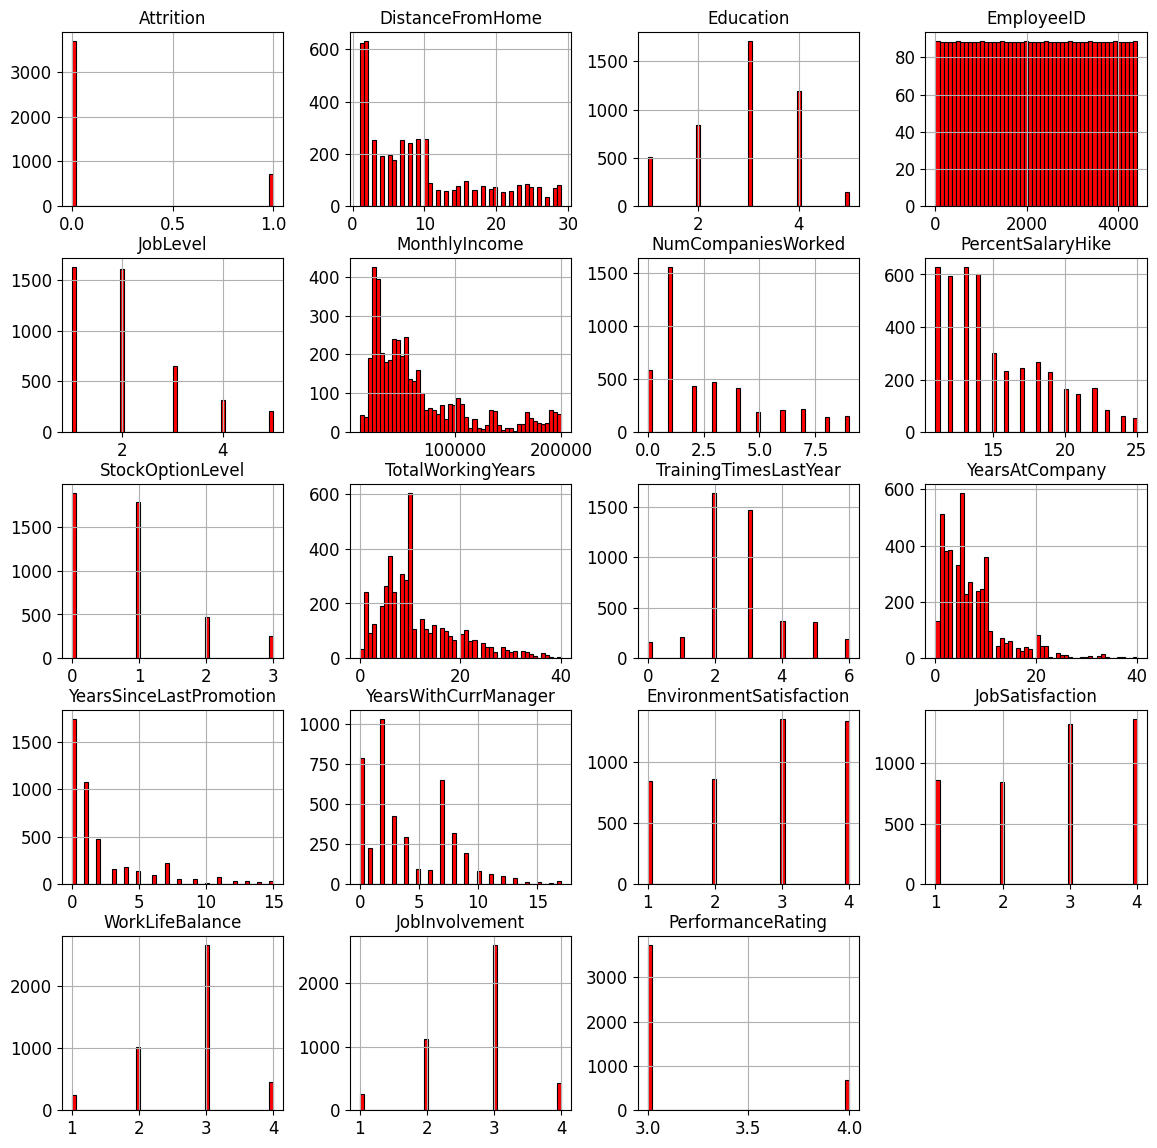

In [87]:
charts = Dataset.hist(facecolor = '#ff0005', edgecolor='#000000', linewidth=0.8, figsize=(14,14), bins=50)

In [83]:
#prepare time dataset
import datetime as dt

for i in in_time[1:]:
    print(i)
    a = dt.datetime.strptime(in_time[i][0], "%Y-%m-%d %H:%M:%S")
    b = dt.datetime.strptime(out_time[i][0], "%Y-%m-%d %H:%M:%S")
    
    print((b-a).total_seconds())

Unnamed: 0


TypeError: strptime() argument 1 must be str, not numpy.int64